## 0. Pre-Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
import scipy.stats as stats

In [2]:
sns.set_style("whitegrid")

## Quais são os produtos mais catalogados? V
## Quais produtos tem mais unidades vendidas? V
## Qual o preço médio dos produtos? V
## Qual a receita dos produtos? V
## Qual material é mais vendido? Qual é menos vendido? V
## Os kits de itens mostram diferença nas vendas e valor?
## O valor do desconto tem relação com o número de vendas?
## Como é a avaliação dos clientes


In [53]:
def plota_variaveis_numericas(dataframe: pd.DataFrame, conjunto: list, titulo: str, modo='barra', tamanho_figura = (15,30), i=0, alvo=None) -> None:
    nrows = int(round(len(conjunto)/2, 0))
    
    if nrows < (len(conjunto)/2):
        nrows += 1

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=tamanho_figura, facecolor='white')
    axes = axes.flatten()
    fig.suptitle(titulo)
    #fig.subplots_adjust(hspace=0.8, wspace=0.3)


    for item in conjunto:
        if modo == 'barra':
            sns.barplot(x=dataframe[alvo], y=dataframe[item], ax=axes[i], color='#435058')
            axes[i].set_title(item)

        elif modo=='histograma':
            sns.histplot(x=dataframe[item], ax=axes[i], color='#435058')
            axes[i].axvline(x=dataframe[item].mean(), linestyle='--', color='red')
            axes[i].axvline(x=dataframe[item].median(), linestyle='--', color='green')
            axes[i].set_title(item + '. Média = {:.2f}, Mediana = {:.2f}'.format(dataframe[item].mean(), dataframe[item].median()))

        if dataframe[item].nunique() > 6:
            axes[i].xaxis.set_tick_params(rotation=90)

        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
        i += 1
   
    fig.tight_layout(pad=2)

def plota_contagens(dataframe: pd.DataFrame, conjunto: list, alvo: str, titulo: str, tamanho_figura = (15,22), i=0) -> None:
    nrows = int(round(len(conjunto)/2, 0))

    if nrows < (len(conjunto)/2):
        nrows += 1

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=tamanho_figura, facecolor='white')
    axes = axes.flatten()
    fig.suptitle(titulo)

    for item in conjunto:
        sns.countplot(x=dataframe[item], ax=axes[i], palette='Paired', hue=dataframe[alvo])
        axes[i].set_title(item)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
        i += 1
        
    fig.tight_layout(pad=2)


def plota_dispersao(dataframe: pd.DataFrame, conjunto: list, var: str, titulo: str, legenda=None, tamanho_figura = (20,12), i=0) -> None:
    nrows = int(round(len(conjunto)/2, 0))

    if nrows < (len(conjunto)/2):
        nrows += 1

    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=tamanho_figura, facecolor='white')
    axes = axes.flatten()
    fig.suptitle(titulo)


    for item in conjunto:
        if legenda is not None:
            sns.scatterplot(x=dataframe[var], y=dataframe[item], ax=axes[i], hue=dataframe[legenda])
        else:
            sns.scatterplot(x=dataframe[var], y=dataframe[item], ax=axes[i])

        i += 1
    fig.tight_layout(pad=2)

def tipifica_roupa(valor, pecas):
    for item in pecas:
        if item in valor:
            return item
    
    return 'outros'

def categoriza_roupas(valor, dicionario):
    for item in dicionario:
        if valor in dicionario[item]:
            return item
    return 'outros'

def verifica_kit(valor):
    if "kit" in valor:
        return True
    else:
        return False
    
def chi_squared_summary(dataframe, cat_1, cat_2, alpha=0.05):
    contingency_table = pd.crosstab(dataframe[cat_1], dataframe[cat_2])
    contingency_table
    chi2, p, graus_liberdade, expected = stats.chi2_contingency(contingency_table)
    x_critico = stats.chi2.ppf(1 - alpha, graus_liberdade)


    # Avalie a significância estatística
    alpha = 0.05  # Nível de significância
    if p < alpha:
        resp = 'A relação é estatísticamente significativa.'
    else:
        resp = 'Não há significado estatístico na relação.'

    data = {
    "Valor p": [p],
    "Estatística qui-quadrado": [chi2],
    "Valor X crítico": [x_critico],
    "Significância estatística": [resp]
    }    

    info = pd.DataFrame(data)
    info.index = ['Teste de hipótese qui-quadrado']
    info = info.T
    return contingency_table, info

In [4]:
df = pd.read_csv('dataset_roupas_marketplacebr_limpo.csv')

## 1. Feature Engineering

Many of the columns in the dataset are categorical, based on qualitative text. The "Title" column can provide an indication of the type of product based on the advertisement. In the ideal situation, there would be a column with the correct type for each product (which would improve the analysis, for sure). In this case, the type is obtained from the extraction of text from the title.

In [5]:
#Dropping duplicates and visualizing first rows of the dataframe
df.head()
df = df.drop_duplicates()
df = df.drop(['Unnamed: 0'], axis=1)

In [6]:
#Making a list from the texts on title column and spliting the words from that list
textos = ' '.join(df['Título'])
palavras = textos.lower().split()

#There are lots of stopwords on title that are not useful for analysis so, we remove them. I'm also removing any words with less than 3 characters
palavras = [palavra for palavra in palavras if palavra not in stopwords.words('portuguese')]
palavras = [palavra for palavra in palavras if len(palavra) > 3]

With the complete list of words from the titles, it's time to count the occurrence of these words. Counting helps determine which product categories are the most popular in order to define the categories on our new column. Since titles can have occurrences of more than one type, the most prominent type apparent in the title is considered.

In [7]:
#Using the counter to identify most common product types
word_count = Counter(palavras)
print(word_count.most_common(100))

[('roupa', 583), ('infantil', 402), ('calça', 396), ('jeans', 333), ('short', 271), ('feminina', 250), ('masculina', 247), ('conjunto', 231), ('feminino', 223), ('bermuda', 207), ('roupas', 190), ('alta', 189), ('cintura', 187), ('plus', 165), ('size', 163), ('bebê', 154), ('shorts', 152), ('lycra', 149), ('academia', 142), ('algodão', 135), ('cuecas', 125), ('masculino', 124), ('atacado', 122), ('menino', 116), ('boxer', 105), ('menina', 105), ('peças', 102), ('lupo', 92), ('ballet', 88), ('body', 82), ('saia', 81), ('moda', 81), ('fitness', 80), ('bumbum', 76), ('original', 67), ('moletom', 67), ('blusa', 66), ('praia', 62), ('tactel', 61), ('costura', 59), ('térmica', 59), ('verão', 59), ('juvenil', 57), ('bermudas', 53), ('premium', 52), ('manga', 52), ('adulto', 52), ('uniforme', 50), ('estampado', 50), ('proteção', 50), ('femininas', 50), ('elastano', 49), ('bebe', 49), ('jogger', 48), ('levanta', 48), ('segunda', 44), ('pele', 44), ('macacão', 44), ('apicultor', 43), ('azul', 42

In [8]:
#Defining a list with product types, list order is based on popularity
pecas = ['calça', 'short', 'conjunto', 'bermuda', 'shorts', 'cuecas', 'ballet', 'body', 'saia', 'blusa', 'bermudas', 'uniforme', 'macacão',
         'cueca', 'camiseta', 'meia', 'calças', 'conjuntos', 'mala', 'cinto', 'pijama', 'camisa', 'boné']

In [9]:
df['Título'] = df['Título'].apply(lambda x: x.lower())
df['tipo_peca'] = df['Título'].apply(lambda x: tipifica_roupa(x, pecas=pecas))
df['kit'] = df['Título'].apply(verifica_kit)
df['receita_prod'] = df['Preco_com_desconto']*df['n_vendidos_categoria']

Still, there are many categories, which doesn't aid in the analysis. Therefore, I create a new column, grouping some types of clothing. The idea behind the new column is to make it easier to read by segment, without losing too much information.

In [10]:
#Categorizing clothes in larger categories
categorias_roupas = {'shorts, bermudas e saias': ['short', 'shorts', 'bermuda', 'bermudas', 'saia'],
              'calças': ['calça', 'calças'],
              'topo': ['blusa', 'camiseta', 'camisa'],
              'uniformes e conjuntos': ['conjunto', 'ballet', 'uniforme', 'macacão', 'conjuntos', 'pijama', 'body'],
              'intimos': ['cuecas', 'cueca', 'meia'],
              'acessorios': ['mala', 'cinto', 'boné']}

In [11]:
df['categoria_roupa'] = df['tipo_peca'].apply(lambda x: categoriza_roupas(x, dicionario=categorias_roupas))

The column descriptions indicate that the values in several of them are unevenly distributed. In other analyses, it might be possible to normalize the distributions to obtain curves closer to the Gaussian one, but there would be a valuable loss of information in this case if we worked with a logarithmic scale. Therefore, my decision was to limit the values of the price and rating columns to the 95th percentile.

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Preco_original,2207.0,114.078777,82.966115,3.0,54.900,88.95,149.895,930.00
Desconto_percentual,2207.0,0.061214,0.102199,0.0,0.000,0.00,0.100,0.66
Preco_com_desconto,2207.0,106.970476,77.485552,3.0,52.325,79.90,139.900,930.00
n_vendidos_categoria,2207.0,857.070231,3513.344821,0.0,5.000,50.00,500.000,50000.00
Nota,1559.0,4.560936,0.362854,2.3,4.400,4.60,4.800,5.00
N_Avaliações,2207.0,144.147259,494.935399,0.0,0.000,10.00,63.000,9077.00
receita_prod,2207.0,107553.423081,598344.296421,0.0,599.275,5190.00,26900.000,11955500.00


In [13]:
#Setting columns to be capped
vars_correcao = ['Preco_original', 'Preco_com_desconto', 'N_Avaliações']
percentil = 0.95

#Capping column values to the 95th percentile
for col in vars_correcao:
    valor_percentil = df[col].quantile(percentil)
    df[col] = df[col].apply(lambda x: x if x <= valor_percentil else valor_percentil)

## 2. Selling information descriptive statistics

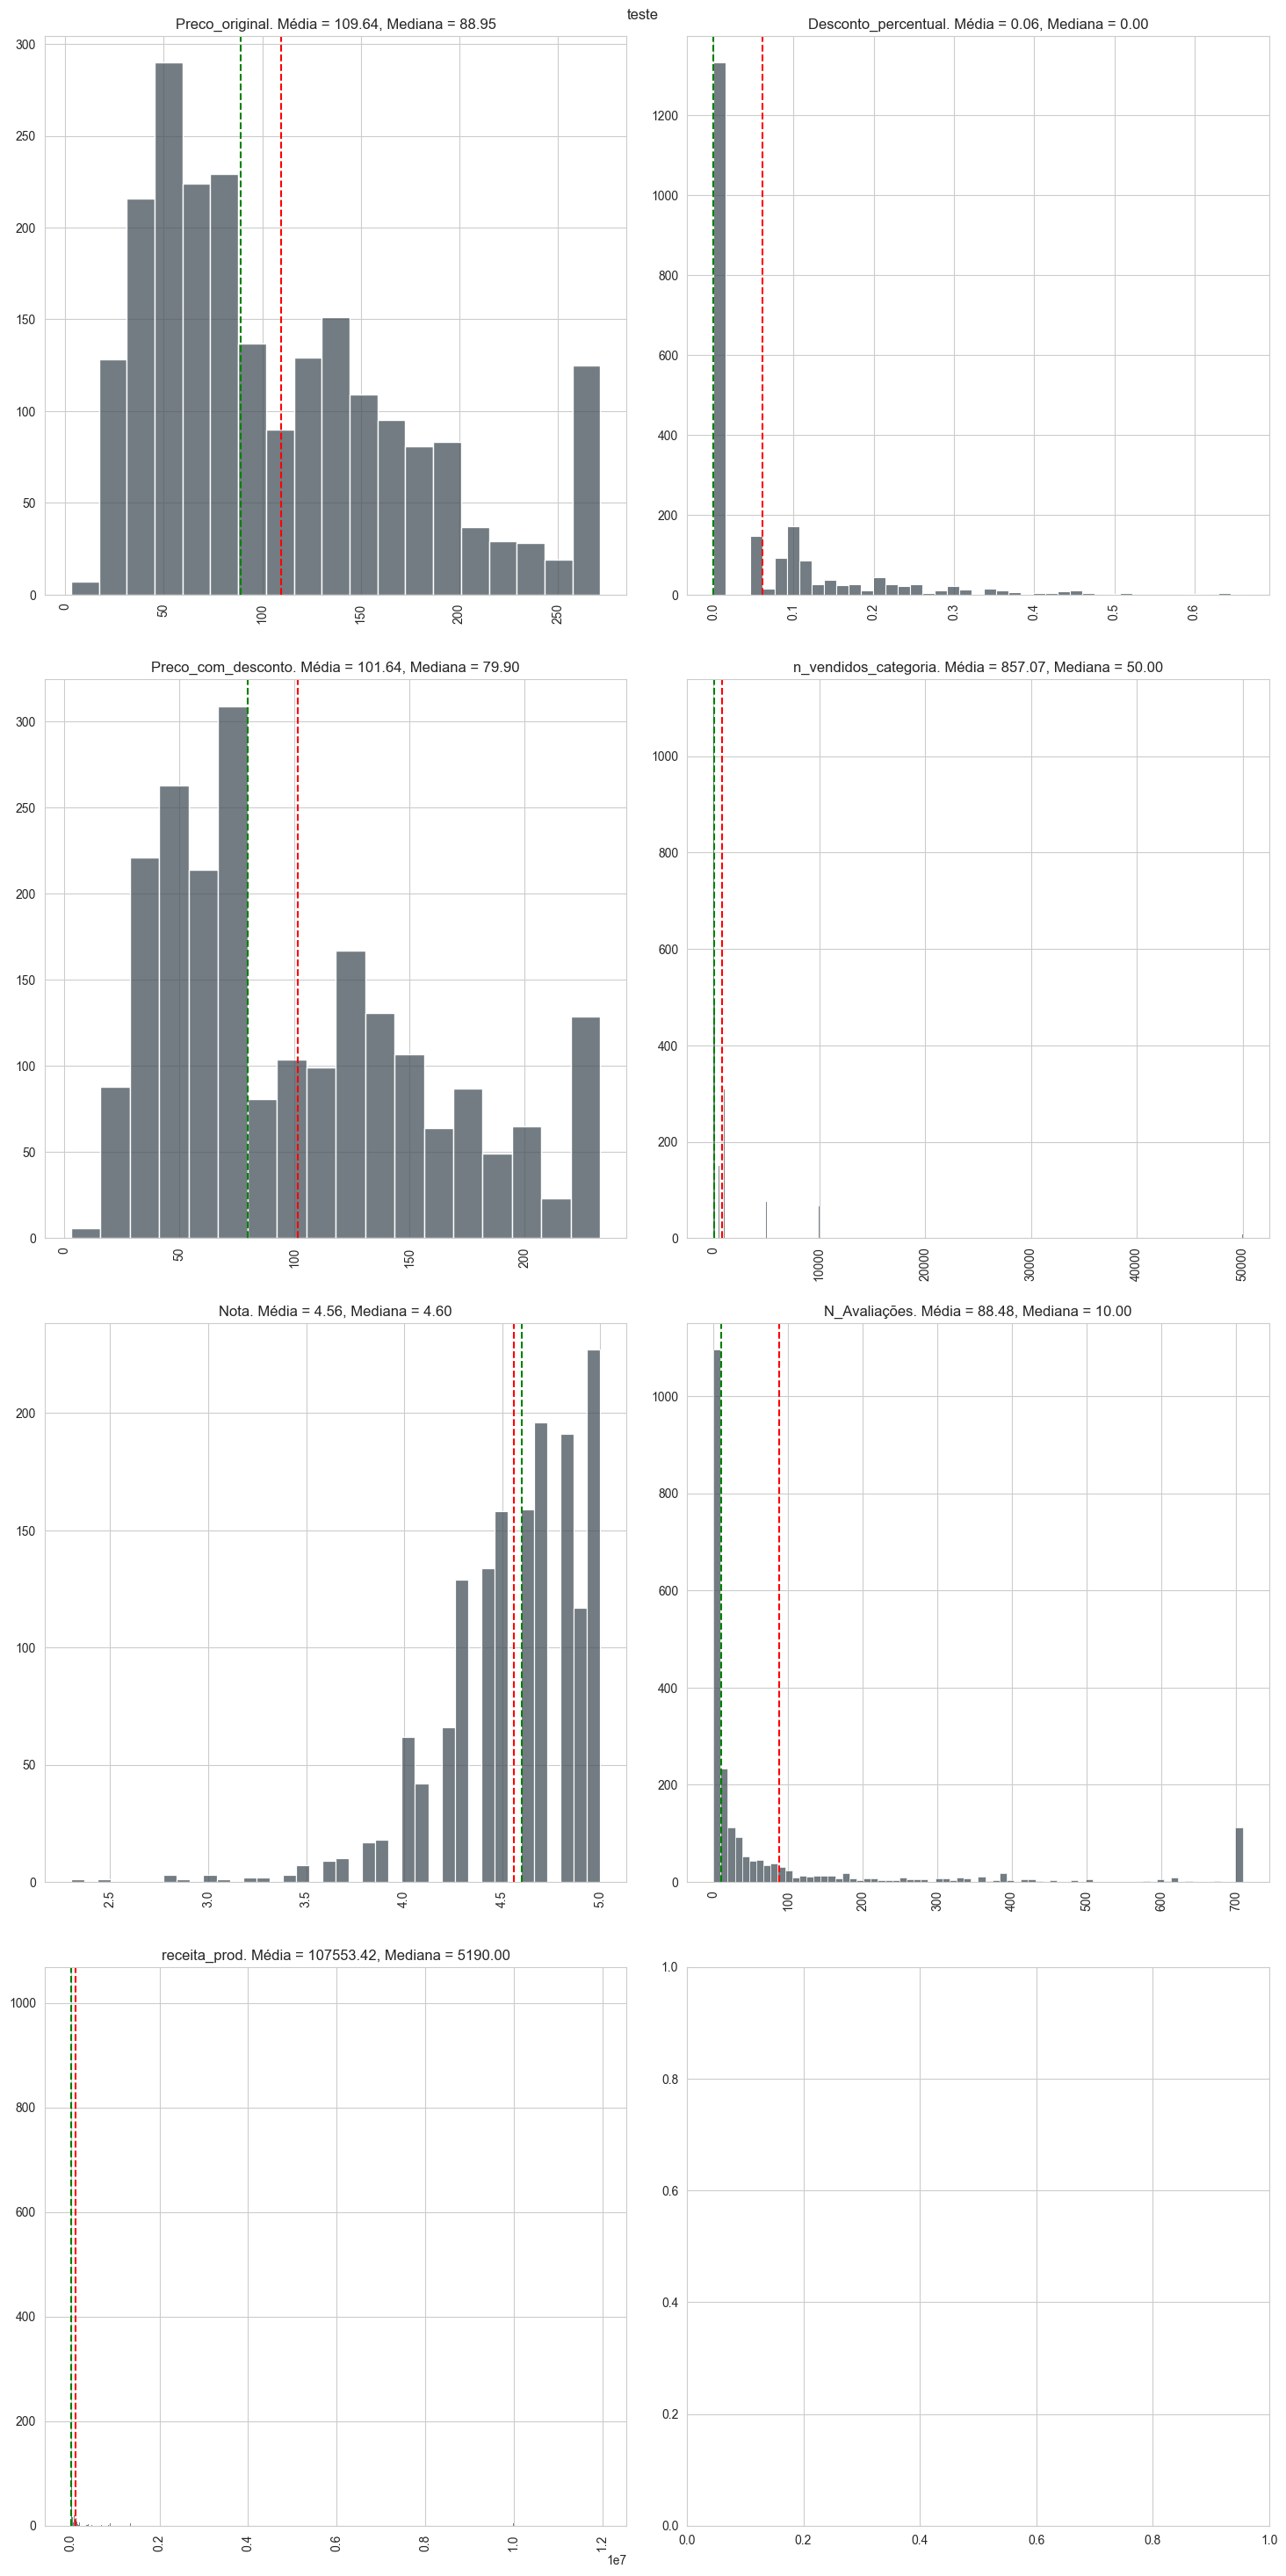

In [14]:
plota_variaveis_numericas(df, df.select_dtypes(include=np.number).columns.to_list(), titulo='teste', modo='histograma')

<AxesSubplot: title={'center': 'Number of advertisements by cloth category'}, xlabel='categoria_roupa'>

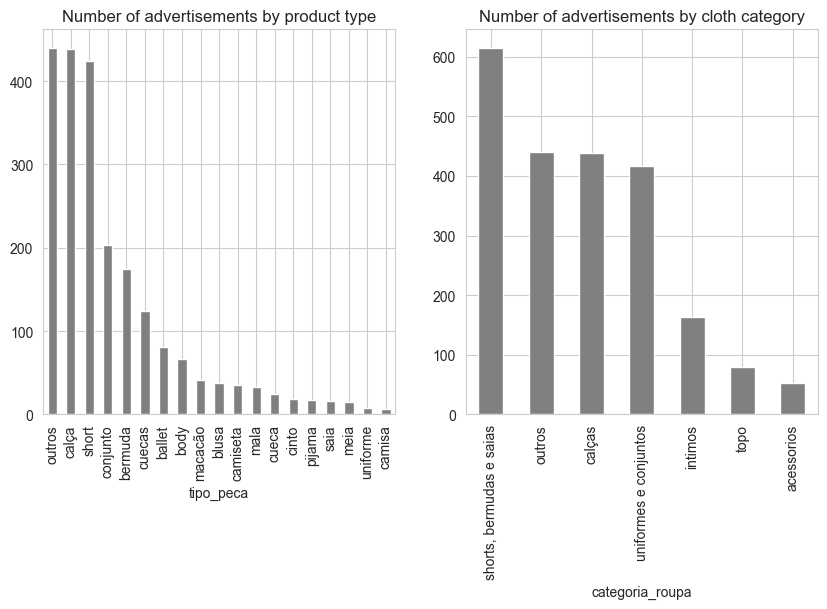

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 21))
df['tipo_peca'].value_counts().plot(kind='bar', color='gray', figsize=(10, 5), title='Number of advertisements by product type', ax=axes[0])
df['categoria_roupa'].value_counts().plot(kind='bar', color='gray', figsize=(10, 5), title='Number of advertisements by cloth category', ax=axes[1])

<AxesSubplot: title={'center': 'Total sales per clothing category'}, xlabel='categoria_roupa'>

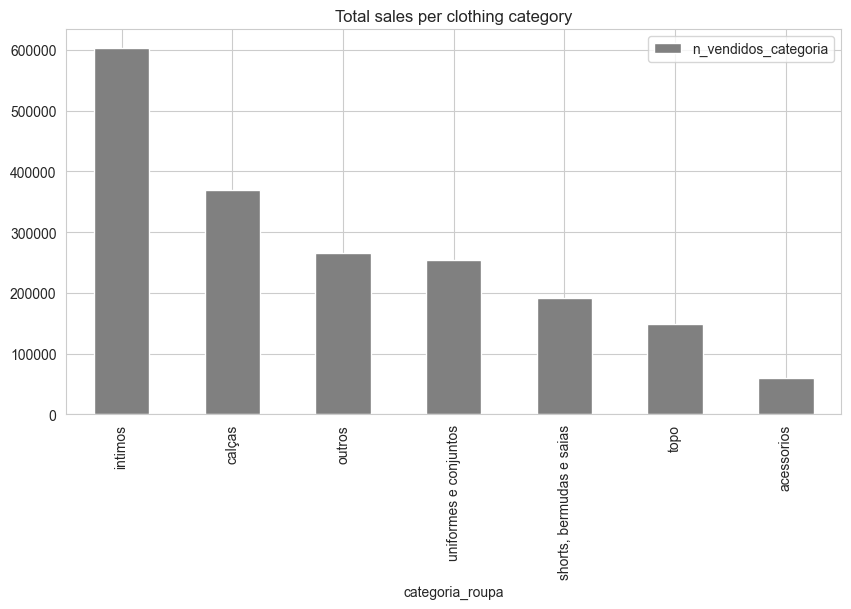

In [16]:
df[['categoria_roupa','n_vendidos_categoria']].groupby('categoria_roupa').sum().sort_values(by='n_vendidos_categoria', ascending=False)\
.plot(kind='bar', color='gray', figsize=(10, 5), title='Total sales per clothing category')

In [17]:
df_categoria_medias = df.groupby('categoria_roupa').mean(numeric_only=True).sort_values(by='Preco_com_desconto', ascending=False)
df_categoria_somas = df.groupby('categoria_roupa').sum(numeric_only=True).sort_values(by='receita_prod', ascending=False)

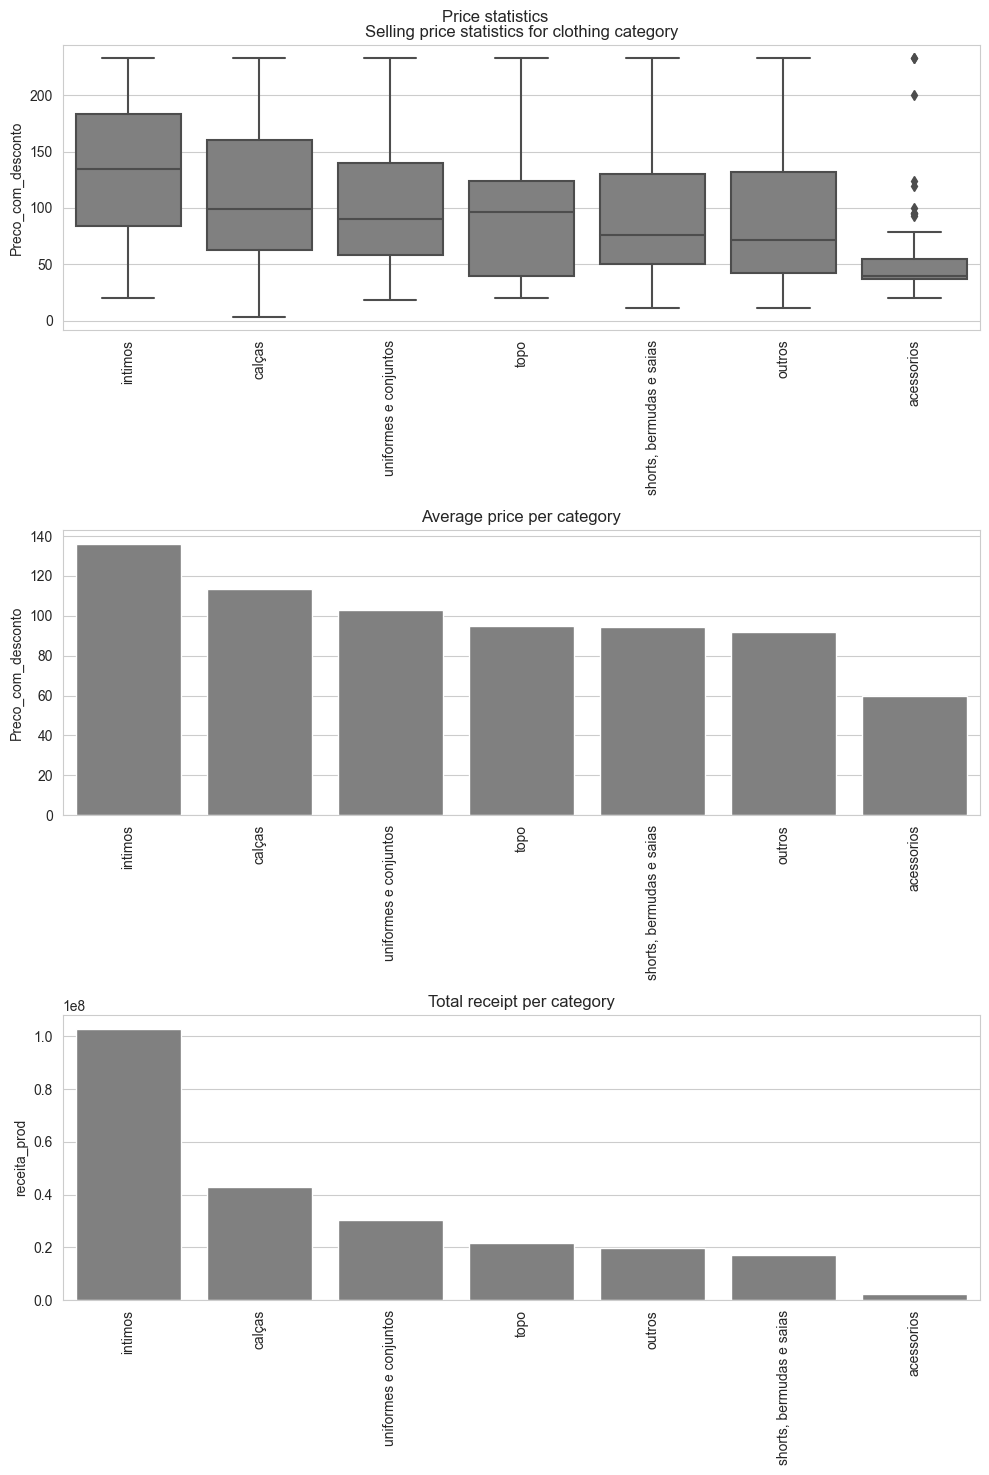

In [18]:
mean_values = df.groupby('categoria_roupa')['Preco_com_desconto'].mean().sort_values(ascending=False)

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
sns.boxplot(x=df['categoria_roupa'], y=df['Preco_com_desconto'].sort_values(ascending=False), data=df, ax=axs[0], color='gray', order=mean_values.index)
sns.barplot(x=df_categoria_medias.index, y=df_categoria_medias['Preco_com_desconto'].sort_values(ascending=False), data=df, ax=axs[1], color='gray')
sns.barplot(x=df_categoria_somas.index, y=df_categoria_somas['receita_prod'], data=df_categoria_somas, ax=axs[2], color='gray')



axs[0].set_title('Selling price statistics for clothing category')
axs[1].set_title('Average price per category')
axs[2].set_title('Total receipt per category')

for i in range(3):
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    axs[i].set_xlabel('')
#axs[0].set_ylim([0,400])

fig.suptitle('Price statistics')
fig.tight_layout()

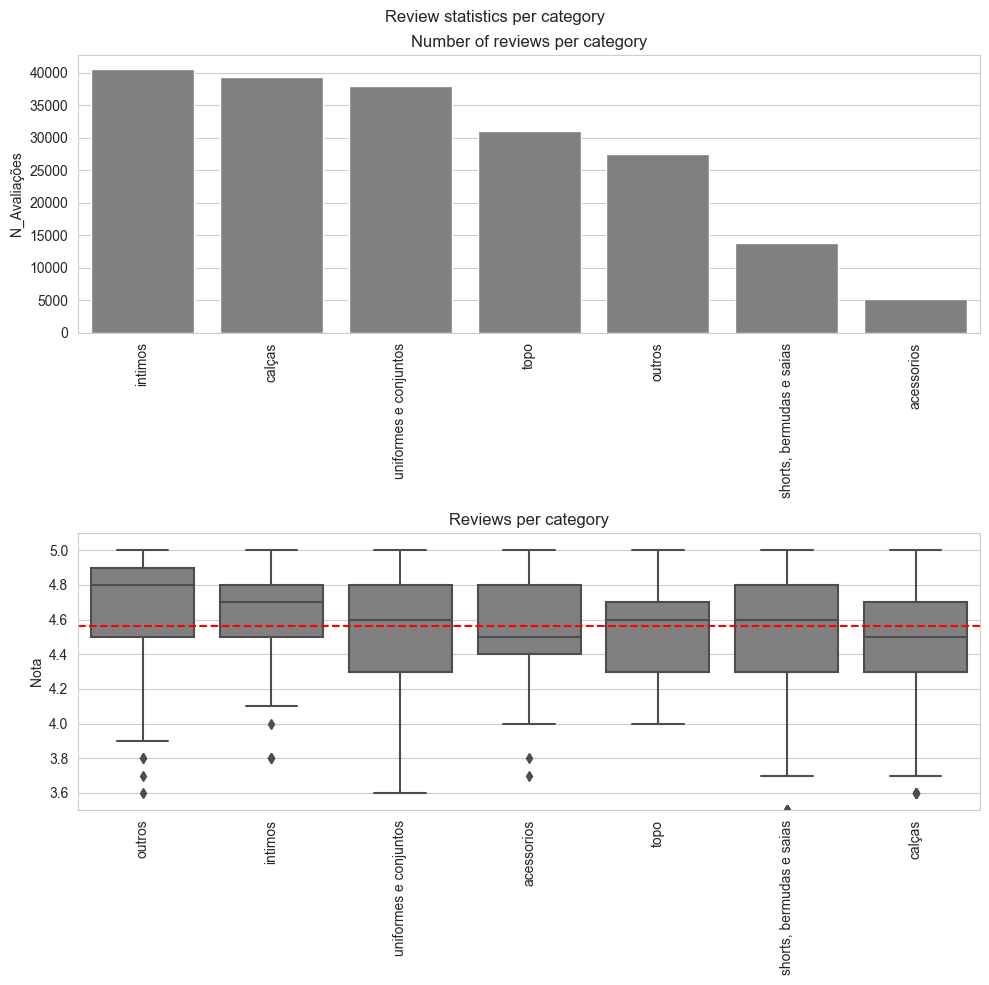

In [19]:
mean_values = df.groupby('categoria_roupa')['Nota'].mean().sort_values(ascending=False)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x=df_categoria_somas.index, y=df_categoria_somas['N_Avaliações'].sort_values(ascending=False), data=df_categoria_somas, ax=axs[0], color='gray')
sns.boxplot(x=df['categoria_roupa'], y=df['Nota'].sort_values(ascending=False), data=df, color='gray', ax=axs[1], order=mean_values.index)

axs[1].axhline(y=df['Nota'].mean(), color='red', linestyle='--')
axs[1].set_ylim([3.5,5.1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

for i in range(2):
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    axs[i].set_xlabel('')

axs[0].set_title('Number of reviews per category')
axs[1].set_title('Reviews per category')
fig.suptitle('Review statistics per category')
fig.tight_layout()


<AxesSubplot: xlabel='categoria_roupa', ylabel='Count'>

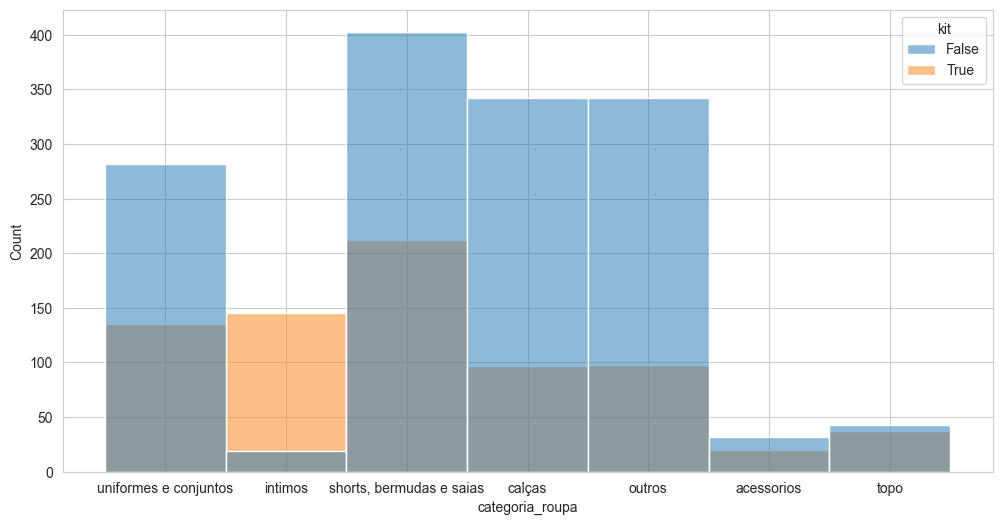

In [20]:
fig = plt.figure(figsize=(12, 6))
counts = df['categoria_roupa'].value_counts().index

sns.histplot(data=df, x='categoria_roupa', hue='kit')

## 3. Selling Inferencial Analysis

In [21]:
avaliacao = [(df['Nota'] >= 4.9) & (df['Nota'] <= 5),
    (df['Nota'] >= 4.6) & (df['Nota'] < 4.9),
    (df['Nota'] >= 4.3) & (df['Nota'] < 4.6),
    (df['Nota'] >= 4) & (df['Nota'] < 4.3),
    (df['Nota'] >= 0) & (df['Nota'] < 4)]

categorias = ['Ótimo', 'Bom', 'Regular', 'Ruim', 'Péssimo']

# Create a new column 'classificacao_nota' based on the mapping
df['classificacao_nota'] = np.select(avaliacao, categorias, default='Sem Nota')

<AxesSubplot: xlabel='classificacao_nota'>

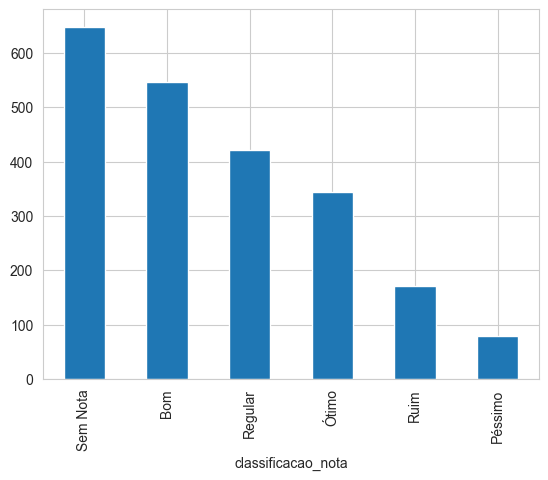

In [22]:
df['classificacao_nota'].value_counts().sort_values(ascending=False).plot(kind='bar')

<AxesSubplot: xlabel='categoria_roupa', ylabel='count'>

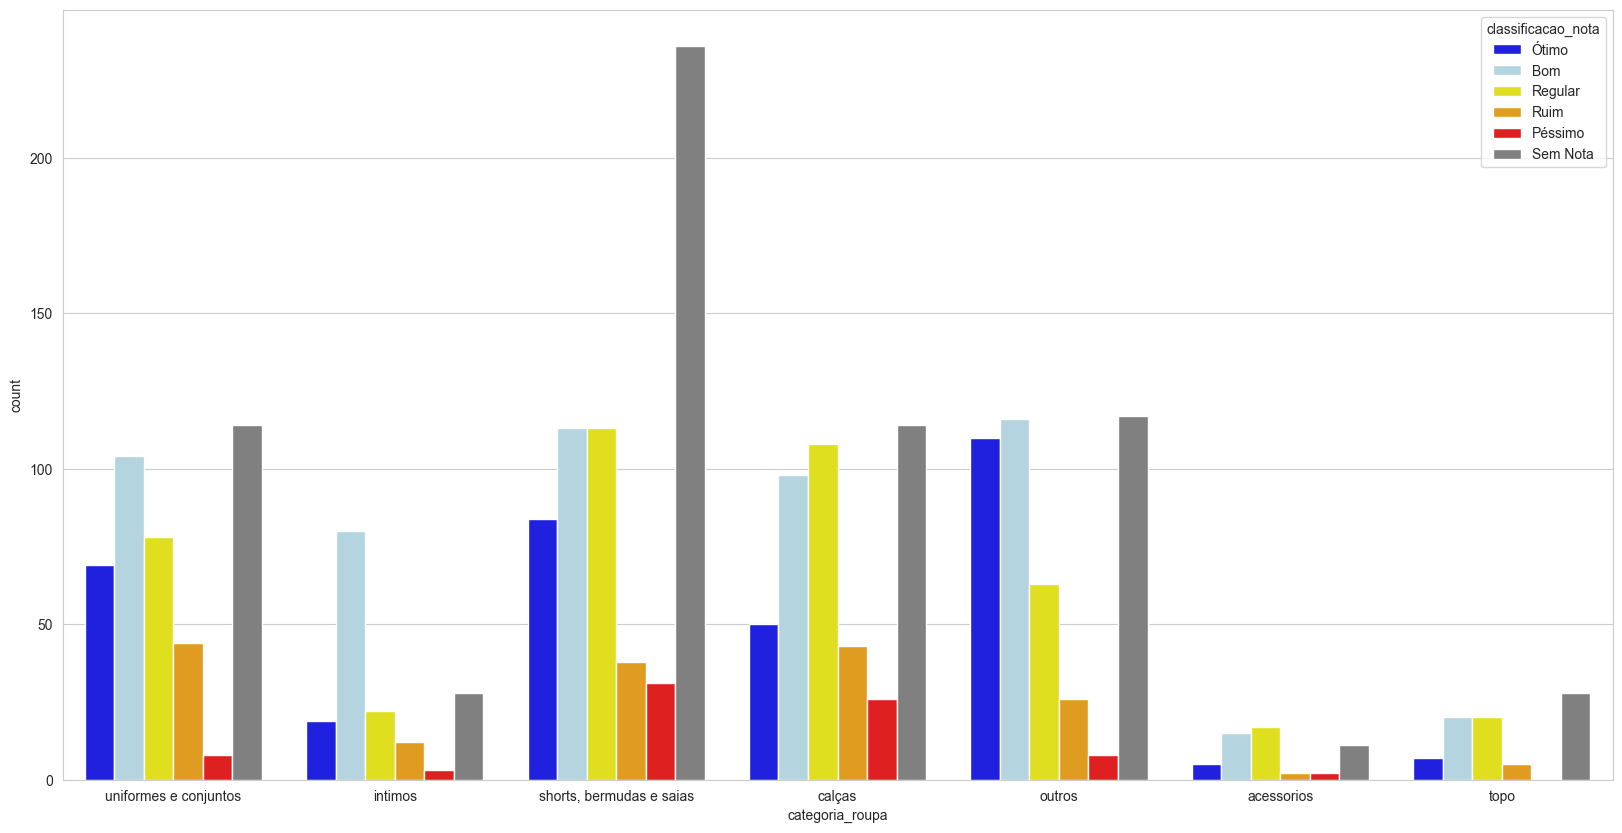

In [64]:
custom_palette = {
    'Ótimo': 'blue',
    'Bom': 'lightblue',
    'Regular': 'yellow',
    'Ruim': 'orange',
    'Péssimo': 'red',
    'Sem Nota': 'gray'
}

df['classificacao_nota'] = pd.Categorical(df['classificacao_nota'], categories=['Ótimo', 'Bom', 'Regular', 'Ruim', 'Péssimo', 'Sem Nota'], ordered=True)

fig = plt.figure(figsize=(20,10))
sns.countplot(df, x='categoria_roupa', hue='classificacao_nota', palette=custom_palette)

In [54]:
chi_squared_summary(df, 'categoria_roupa', 'classificacao_nota')

(classificacao_nota        Bom  Péssimo  Regular  Ruim  Sem Nota  Ótimo
 categoria_roupa                                                       
 acessorios                 15        2       17     2        11      5
 calças                     98       26      108    43       114     50
 intimos                    80        3       22    12        28     19
 outros                    116        8       63    26       117    110
 shorts, bermudas e saias  113       31      113    38       236     84
 topo                       20        0       20     5        28      7
 uniformes e conjuntos     104        8       78    44       114     69,
                                         Teste de hipótese qui-quadrado
 Valor p                                                            0.0
 Estatística qui-quadrado                                    173.702433
 Valor X crítico                                              43.772972
 Significância estatística  A relação é estatísticamente signif

In [55]:
chi_squared_summary(df, 'categoria_roupa', 'kit')

(kit                       False  True 
 categoria_roupa                       
 acessorios                   32     20
 calças                      342     97
 intimos                      19    145
 outros                      342     98
 shorts, bermudas e saias    403    212
 topo                         43     37
 uniformes e conjuntos       282    135,
                                         Teste de hipótese qui-quadrado
 Valor p                                                            0.0
 Estatística qui-quadrado                                    278.527408
 Valor X crítico                                              12.591587
 Significância estatística  A relação é estatísticamente significativa.)

In [56]:
chi_squared_summary(df, 'kit', 'classificacao_nota')

(classificacao_nota  Bom  Péssimo  Regular  Ruim  Sem Nota  Ótimo
 kit                                                             
 False               351       44      224   115       463    266
 True                195       34      197    55       185     78,
                                         Teste de hipótese qui-quadrado
 Valor p                                                            0.0
 Estatística qui-quadrado                                     63.246801
 Valor X crítico                                              11.070498
 Significância estatística  A relação é estatísticamente significativa.)